In [1]:

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/Dropbox/code/python_utilities/')
from python_data_functions import extract_months
from python_met_functions import sat_vap_pres
from python_data_functions import mk_test
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText




/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
data_dir = '/Users/gbromley/Dropbox/CRUTS4.01/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'cru_ts4.01.1901.2016.tmp.dat.nc'
nc_temp = xr.open_dataset(data_dir+temp_file)


In [5]:
t2m = nc_temp['tmp']


In [6]:
t_season='AMJ'
t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2016-01-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38
t2m = t2m.sel(lat=slice(ext_s-5,ext_n+5),lon=slice(ext_w-5,ext_e+5))
#ggw_lat,ggw_lon = 48.18, -106.635

In [ ]:
test = t2m['lat']

In [7]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))
#grab the months interested in
t2m_months = t2m_slice.sel(time=extract_months(t2m_slice['time.month'],t_months[0],t_months[-1]))
#create month averages
t2m_months_avg = t2m_months.groupby('time.year').mean(dim='time')

#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1980-01-01','2011-01-01'))
#grab the months
t2m_clim_months_30 = t2m_clim_30.sel(time=extract_months(t2m_clim_30['time.month'],t_months[0],t_months[-1]))
#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_months_30.mean(dim='time')

In [ ]:
test = t2m_clim_months_30.groupby('time.month').mean(dim='time')

In [ ]:
len(t2m_months_avg)


In [8]:
#create 2d structure to hold slope
spatial_trend = t2m.isel(time=1).copy(deep=True)
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'


slope_scipy = t2m.isel(time=1).copy(deep=True)
#create 2d structure to hold pvalues
pvalues= t2m.isel(time=1).copy(deep=True)
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [14]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
corr_vals = np.arange(0,len(anom.year))
corr_vals = sm.add_constant(corr_vals)
for i in np.arange(0,len(t2m['lat'])):
    for j in np.arange(0,len(t2m['lon'])):
        series = t2m_months_avg[:,i,j]
        anom = series - t2m_clim_months_avg[i,j]
        ac_coe = sm.tsa.stattools.acf(series.values)
        model = sm.OLS(series.values,corr_vals_2)
        #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
        results = model.fit()
        #print(results.params)
        slope = results.params[1]
        
        adjusted_error = results.bse[1] * (np.sqrt((1-ac_coe[1])/(1+ac_coe[1])))
        t_value = ((slope-0.02)/adjusted_error)
        #one-sided lower
        p_value = stats.t.cdf(t_value, results.df_resid)
        #t_value = ((slope - 0.02)/results.bse[1])
        #p_value = stats.t.cdf(t_value, results.df_resid)
        #p_value = stats.t.sf(results.tvalues[0], results.df_resid)
        spatial_trend[i,j]=slope*10
        #slope_scipy[i,j] = slope_2*10
        pvalues[i,j]= p_value

In [38]:
54*76

4104

In [15]:
pvals = pvalues.where(pvalues.values < 0.05)

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [67]:
pvals.plot()

ValueError: zero-size array to reduction operation minimum which has no identity

In [60]:
reject, pvales_test, a,b = sm.stats.multipletests(pvals.values.dropna().flatten(), alpha=0.05,method='fdr_bh')

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [59]:
pvales_test.min()

/Users/gbromley/anaconda3/envs/paper1_research/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


nan

In [ ]:
#spatial_trend.to_dataset().to_netcdf(data_dir+'CRU_temp_tobias'+t_season+'_'+'1970'+'.nc')

In [ ]:
pvalues.to_dataset().to_netcdf(t_season+'_1970_pvalues.nc')

<xarray.DataArray 't2m_trend_pvalues' ()>
array(nan)
Coordinates:
    time     datetime64[ns] 1901-02-15T00:00:01.199177

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'axes', 'color', 'edgecolor'
  s)


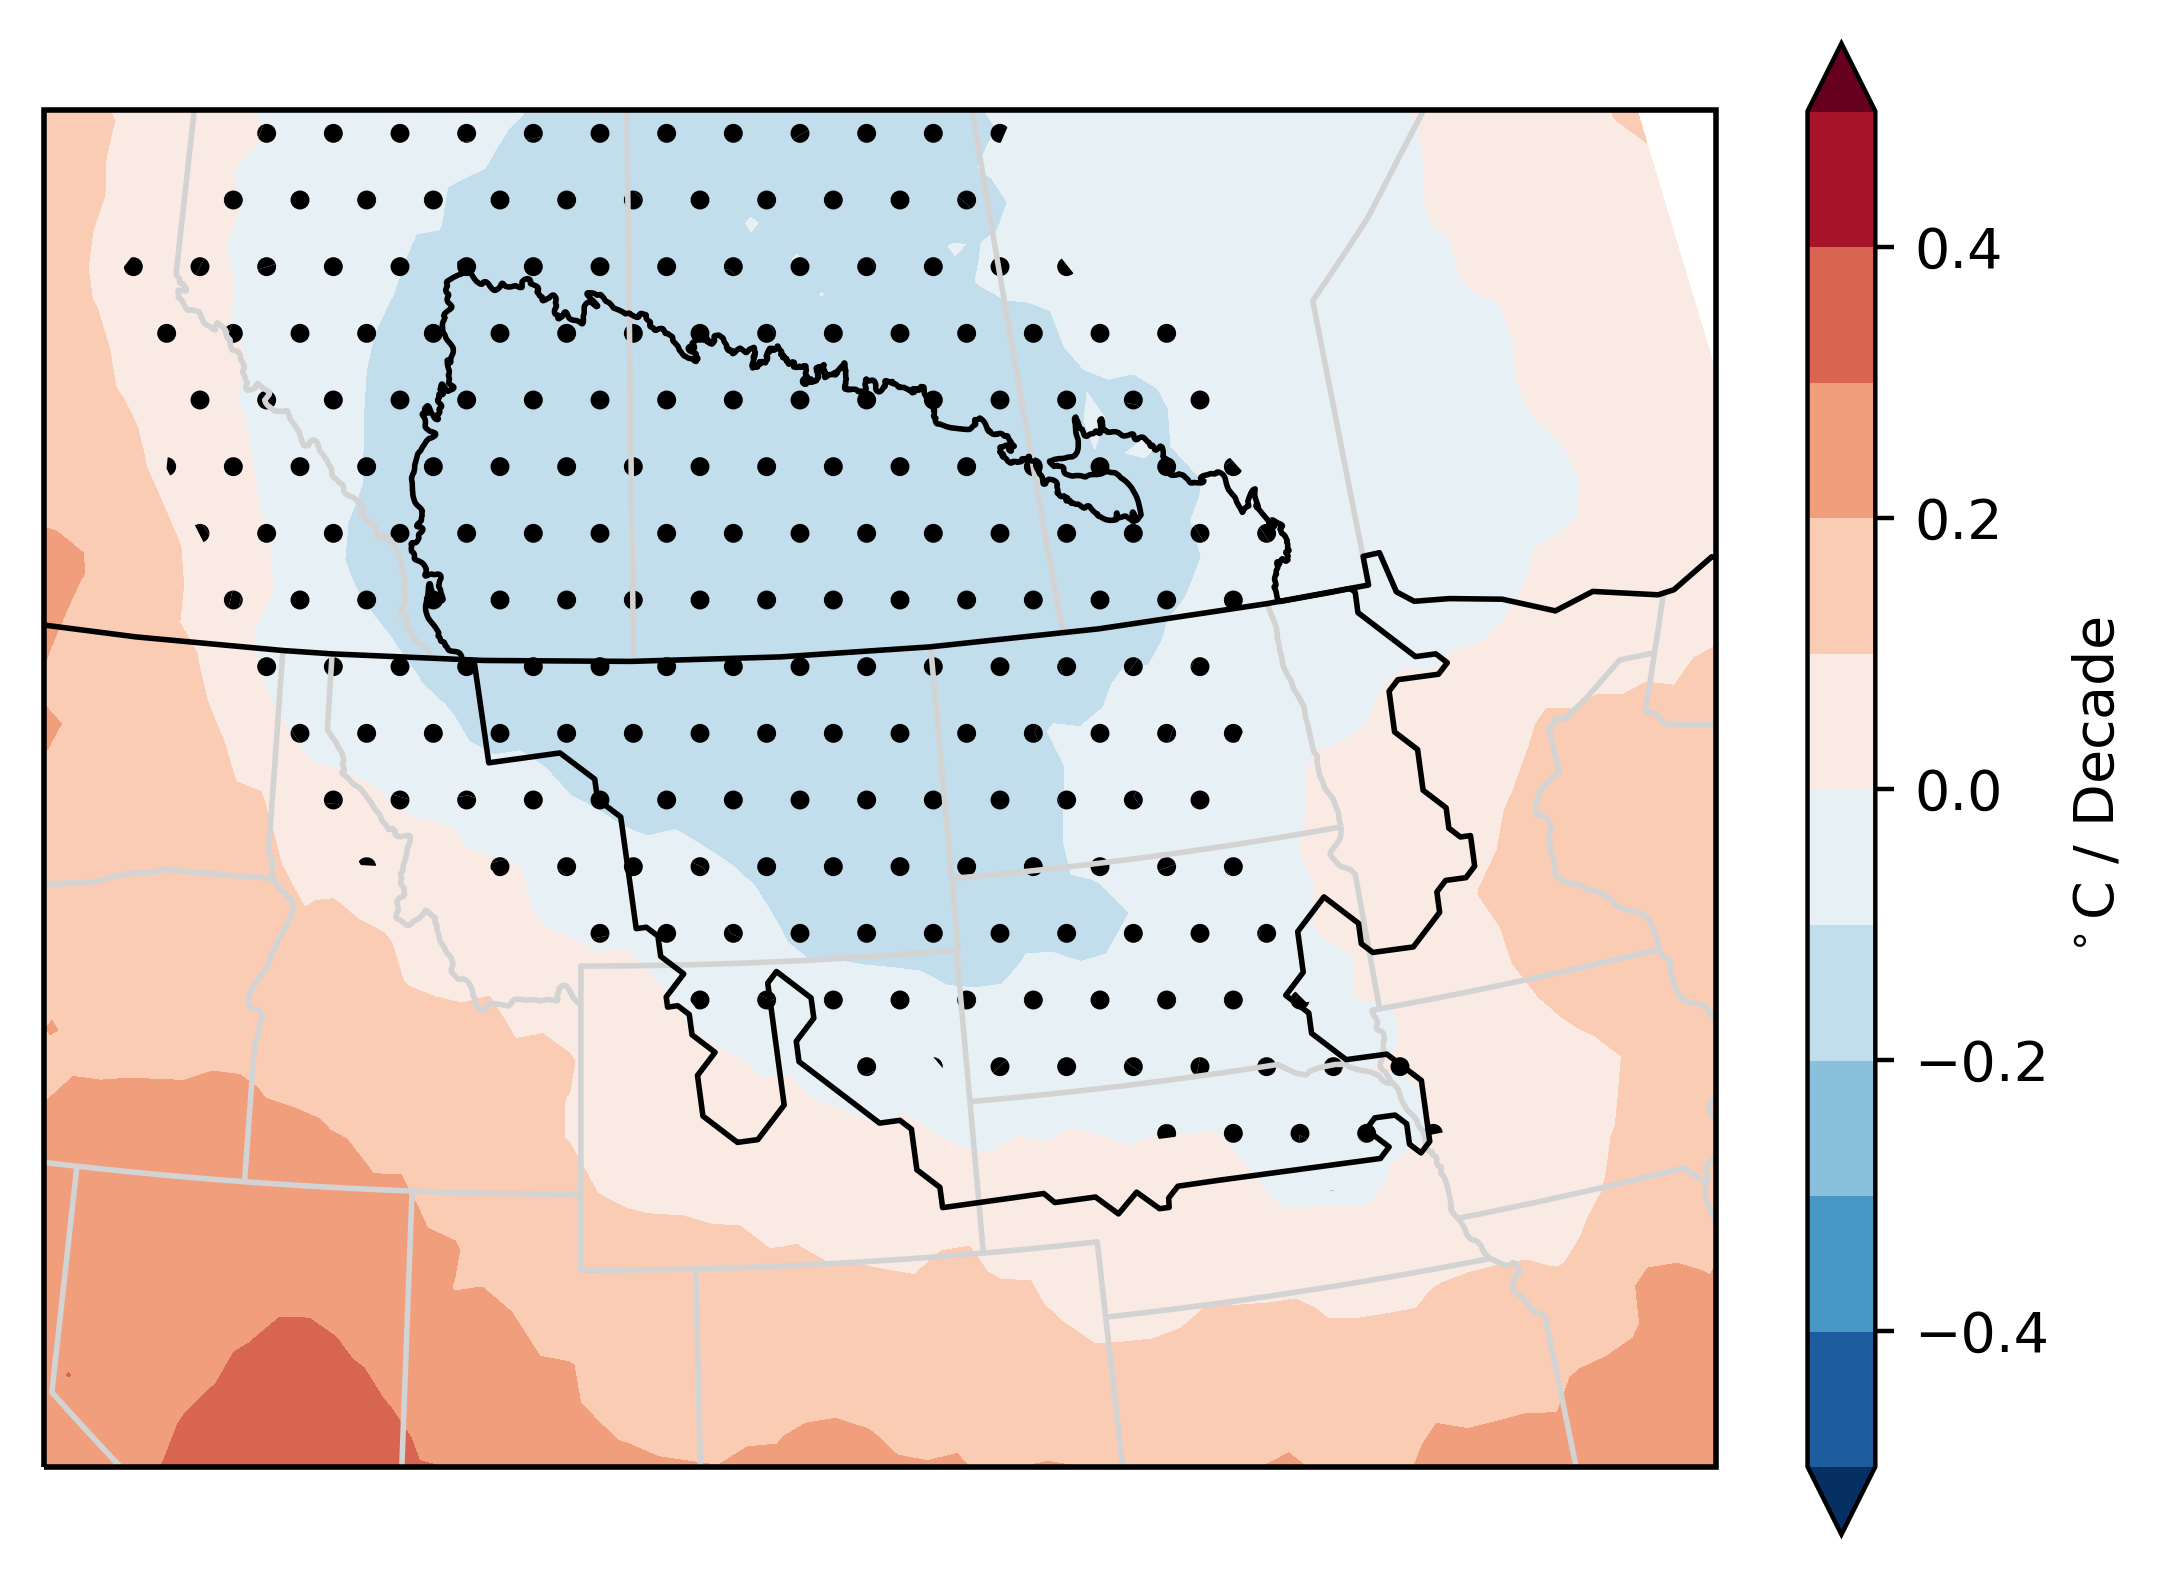

In [20]:
levs = [-.6,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.6]

fig = plt.figure(1,figsize=(13,7), dpi=400.0)
projection = ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None)
ax1 = plt.subplot(1,2,1, projection = projection)
#ax1 = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax1.set_global()
#test = spatial_trend.plot.pcolormesh(axes = ax1, transform=ccrs.PlateCarree(),vmin=-0.8, vmax=0.8, cmap='RdBu_r',add_colorbar = False)
test = plt.contourf(spatial_trend.lon,spatial_trend.lat,spatial_trend[:,:].values,transform=ccrs.PlateCarree(),levels=levs,cmap='RdBu_r', extend='both')

#ax = plt.axes(projection=ccrs.LambertConformal())
pvals.plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)
ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
shape_feature = ShapelyFeature(Reader('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/Study_Area_08_01_17.shp').geometries(),crs=ccrs.PlateCarree(), facecolor='none',edgecolor='black')
ax1.add_feature(shape_feature)
#plt.plot(ggw_lon, ggw_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.plot(ftp_lon, ftp_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.text(ftp_lon+0.5, ftp_lat, 'US-FPe', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
#plt.text(ggw_lon-2, ggw_lat, 'GGW', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
ax1.title.set_visible(False)
cb = plt.colorbar(test, cmap='RdBu_r',fraction=0.037)
cb.set_label('$^\circ$C / Decade',fontsize=10)
#cb.ax.tick_params(labelsize=8)
#plt.text(0, 1,'a', ha='center', va='center', backgroundcolor='lightgray')
#anchored_text = AnchoredText("1", loc=2)
#ax1.add_artist(anchored_text)

plt.savefig('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/CRU_temp_sig_trends'+t_season+'_1970.png',bbox_inches='tight')
plt.show()
